In [41]:
import sys
sys.path.append('/home/amigos/ros/src/necst/lib')
sys.path.append('/home/amigos/git/analy_n2data/script')
if not sys.argv[1] == "-f":
    path = sys.argv[1]
    mode = "commandline"
else:
    # 手動で解析する場合はデータのあるpathを指定してください
    #path path = "/home/amigos/hdd/data/radio_pointing_line_9/n20190920001709_12CO_2-1_cross_OriKL_pointing" = "/home/amigos/hdd/data/radio_pointing_line_9/n20190919221022_12CO_2-1_cross_OriKL_pointing"
    path = "/home/amigos/hdd/data/radio_pointing_line_9/n20190920001709_12CO_2-1_cross_OriKL_pointing"
    path = "/home/amigos/hdd/data/radio_pointing_line_9/n20190920012521_12CO_2-1_cross_OriKL_pointing"
    mode = "notebook"

In [42]:
#import n2df
import necstdb
import numpy
import matplotlib.pyplot as plt
import pickle
#from astropy.io import fits
import os
from scipy.optimize import curve_fit

In [43]:
import make_dset
if True:#not os.path.exists(os.path.join(path, "obsmode.npy")):
    _d, data = make_dset.get_data(path, "05")
    numpy.save(os.path.join(path, "obsmode.npy"), _d)
else:
    _d = numpy.load(os.path.join(path, "obsmode.npy"))
    data = make_dset.get_data2(path, "05")

100%|██████████| 3/3 [00:00<00:00, 24.51it/s]

HOT 0.0
0.0 OFF -30.0 -30.0
0.0 OFF -30.0 -60.0
0.0 OFF -30.0 0.0
0.0 OFF -30.0 30.0
0.0 OFF -30.0 60.0
0.0 OFF -60.0 -30.0
0.0 OFF -60.0 -60.0
0.0 OFF -60.0 0.0
0.0 OFF -60.0 30.0
0.0 OFF -60.0 60.0
0.0 OFF 0.0 -30.0
0.0 OFF 0.0 -60.0
0.0 OFF 0.0 0.0
0.0 OFF 0.0 30.0
0.0 OFF 0.0 60.0
0.0 OFF 30.0 -30.0
0.0 OFF 30.0 -60.0
0.0 OFF 30.0 0.0
0.0 OFF 30.0 30.0
0.0 OFF 30.0 60.0
0.0 OFF 60.0 -30.0
0.0 OFF 60.0 -60.0
0.0 OFF 60.0 0.0
0.0 OFF 60.0 30.0
0.0 OFF 60.0 60.0
1.0 OFF -30.0 -30.0
1.0 OFF -30.0 -60.0
1.0 OFF -30.0 30.0
1.0 OFF -30.0 60.0
1.0 OFF -60.0 -30.0
1.0 OFF -60.0 -60.0
1.0 OFF -60.0 30.0
1.0 OFF -60.0 60.0
1.0 OFF 0.0 -30.0
1.0 OFF 0.0 -60.0
1.0 OFF 0.0 30.0
1.0 OFF 0.0 60.0
1.0 OFF 30.0 -30.0
1.0 OFF 30.0 -60.0
1.0 OFF 30.0 30.0
1.0 OFF 30.0 60.0
1.0 OFF 60.0 -30.0
1.0 OFF 60.0 -60.0
1.0 OFF 60.0 30.0
1.0 OFF 60.0 60.0
2.0 OFF -30.0 -30.0
2.0 OFF -30.0 -60.0
2.0 OFF -30.0 0.0
2.0 OFF -30.0 30.0
2.0 OFF -30.0 60.0
2.0 OFF -60.0 -30.0
2.0 OFF -60.0 -60.0
2.0 OFF -60.0 0.0
2.0 

In [44]:
_d = numpy.array(_d)
#time = data.T[1].tolist()
mode = _d.T[0].tolist()
subscan = _d.T[1].tolist()
_lam = _d.T[2].tolist()
_bet = _d.T[3].tolist()

In [69]:
ori_d = data.T[2:].T

In [70]:
def f(x, a, b, c):
    return a*x**2 + b*x + c

def gaussian(x, a, mu, gamma):
    return a * numpy.exp(- gamma * (x - mu) **2)

In [48]:
def calc_integdata(IF, data_list, mode_list, lam, bet, scan_list, mi, ma, width, integ_mi, integ_ma):

#     data_list = data_list[IF-1]
#     mode_list = mode_list[IF-1]
#     lam = lam[IF-1]
#     bet = bet[IF-1]
#     scan_list = scan_list[IF-1]
    data_list = data_list[0]
    mode_list = mode_list[0]
    lam = lam[0]
    bet = bet[0]
    scan_list = scan_list[0]
    
    xmask = []
    ymask = []
    hotmask = []
    offmask = []
    print(mode_list)
    for i in range(len(mode_list)):  
        print(mode_list[i])
        if mode_list[i] == 'HOT':
            xmask.append(0)
            ymask.append(0)
            hotmask.append(1)
            offmask.append(0)
        elif mode_list[i] == 'OFF':
            xmask.append(0)
            ymask.append(0)
            hotmask.append(0)
            offmask.append(1)
        elif scan_list[i] == 1 and mode_list[i] == 'ON':
            xmask.append(1)
            ymask.append(0)
            hotmask.append(0)
            offmask.append(0)
        elif scan_list[i] == 2 and mode_list[i] == 'ON':
            xmask.append(0)
            ymask.append(1)
            hotmask.append(0)
            offmask.append(0)
           
    # calc Ta*
    print("xmask, ymask, hotmask, offmask")
    print(xmask, ymask, hotmask, offmask)

    tmp = []
    for i in range(len(hotmask)):
        if hotmask[i] == 1:
            if len(tmp) == 0:
                for j in range(i+1):
                    tmp.append(data_list[i])
            else:
                tmp.append(data_list[i])
        else:
            if len(tmp) == 0:
                pass
            else:
                tmp.append(tmp[-1])
    HOTlist = numpy.array(tmp)
    
    tmp = []
    for i in range(len(offmask)):
        if offmask[i] == 1:
            if len(tmp) == 0:
                for j in range(i+1):
                    tmp.append(data_list[i])
            else:
                tmp.append(data_list[i])
        else:
            if len(tmp) == 0:
                pass
            else:
                tmp.append(tmp[-1])
    OFFlist = numpy.array(tmp)
    
    ONlist = numpy.array(data_list)
    print(len(ONlist))
    print(len(OFFlist))
    print(len(HOTlist))
    Taslist = (ONlist - OFFlist)/(HOTlist - OFFlist)*300
    
    x = numpy.linspace(0, 32768, 32768)

    rTaslist_tmp = []
    rtmp = []
    for i in range(len(Taslist)):
        base = []
        start = int(numpy.argmax(Taslist[i][int(mi):int(ma)]) + (mi - width))
        end = int(numpy.argmax(Taslist[i][int(mi):int(ma)]) + (mi + width))
        dif = end - start
        base.extend(Taslist[i])
        base[start:end] = []
        param = numpy.polyfit(x[:32768-dif], base, 2)
        rTas = Taslist[i] - f(x, *param)
        rTaslist_tmp.append(rTas)
    rTaslist = numpy.array(rTaslist_tmp)
    
# create data for plot
    xscan_Ta = []
    xscan_x = []
    xscan_y = []
    
    yscan_Ta = []
    yscan_x = []
    yscan_y = []

    for i in range(len(xmask)):
        if xmask[i] == 1:
            xscan_Ta.append(rTaslist[i])
            xscan_x.append(lam[i])
            xscan_y.append(bet[i])
        else:
            pass

    for i in range(len(ymask)):
        if ymask[i] == 1:
            yscan_Ta.append(rTaslist[i])
            yscan_x.append(lam[i])
            yscan_y.append(bet[i])
        else:
            pass

    # TA* integration
    xscan_integ = []
    yscan_integ = []
    for i in range(len(xscan_Ta)):
        lx = xscan_Ta[i]
        xscan_integ.append(numpy.sum(lx[int(integ_mi):int(integ_ma)]))

    for i in range(len(yscan_Ta)):
        ly = yscan_Ta[i]
        yscan_integ.append(numpy.sum(ly[int(integ_mi):int(integ_ma)]))
        
    xscan_x = list(map(float, xscan_x))
    xscan_y = list(map(float, xscan_y))
    yscan_x = list(map(float, yscan_x))
    yscan_y = list(map(float, yscan_y))
    return xscan_integ, xscan_x, xscan_y, yscan_integ, yscan_x, yscan_y, xscan_Ta, yscan_Ta, Taslist, OFFlist, HOTlist, ONlist

In [49]:
para_init = numpy.array([25000., 0.1, 0.0001])
finename = ''

In [52]:
data_list = []
mode_list = []
scan_list = []
lam = []
bet = []

In [53]:
for h in range(1):
    #d_ = d[h+1]
    d_ = ori_d
    d_list = []
    m_list = []
    s_list = []
    la_list = []
    be_list = []
    tmp = numpy.zeros(32768)
    for i in range(len(d_)):
        print([subscan[i], mode[i]], _lam[i])
        if subscan[i] == "1.0" and mode[i] == 'ON':
            tmp += d_[i]
            #if subscan[i+1] == "2.0" or mode[i+1] == 'OFF' or mode[i+1] == 'HOT':
            if subscan[i+1] != subscan[i] or i == len(d_)-1 or _lam[i+1] != _lam[i]:
                d_list.append(tmp)
                m_list.append('ON')
                la_list.append(_lam[i])
                be_list.append(_bet[i])
                s_list.append(1)
                tmp = numpy.zeros(32768)
            else:
                pass
        elif subscan[i] == "2.0" and mode[i] == 'ON':
            tmp += d_[i]
            #if subscan[i+1] == "1.0" or mode[i+1] == 'OFF' or mode[i+1] == 'HOT':
            if subscan[i+1] != subscan[i] or i == len(d_)-1 or _lam[i+1] != _lam[i]:
                d_list.append(tmp)
                m_list.append('ON')
                la_list.append(_lam[i])
                be_list.append(_bet[i])
                s_list.append(2)
                tmp = numpy.zeros(32768)
            else:
                pass
        elif mode[i] == 'OFF':
            tmp += d_[i]
            #if mode[i+1] == 'ON' or mode[i+1] == 'HOT':
            if mode[i+1] != 'OFF':
                d_list.append(tmp)
                m_list.append('OFF')
                la_list.append(_lam[i])
                be_list.append(_bet[i])
                if subscan[i] == "1.0":
                    s_list.append(1)
                else:
                    s_list.append(2)
                tmp = numpy.zeros(32768)
            else:
                pass       
        elif mode[i] == 'HOT':
            tmp += d_[i]
            if i == len(d_)-1:
                d_list.append(tmp)
                m_list.append('HOT')
                la_list.append(0)
                be_list.append(0)
                if subscan[i] == "1.0":
                    s_list.append(1)
                else:
                    s_list.append(2)
                tmp = numpy.zeros(32768)
            else:
                if mode[i+1] != 'HOT':
                #if mode[i+1] == 'ON' or mode[i+1] == 'OFF':
                    d_list.append(tmp)
                    m_list.append('HOT')
                    la_list.append(0)
                    be_list.append(0)
                    if subscan[i] == "1.0":
                        s_list.append(1)
                    else:
                        s_list.append(2)
                    tmp = numpy.zeros(32768)
                else:
                    pass
        else:
            print("check")
    data_list.append(d_list)
    mode_list.append(m_list)
    lam.append(la_list)
    bet.append(be_list)
    scan_list.append(s_list)

['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0

['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0
['1.0', 'ON'] -30.0


['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0', 'OFF'] 60.0
['1.0',

['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0
check
['0', '0'] 0

['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'ON'] 0.0
['2.0', 'O

In [68]:
mi=10000
ma=30000
width=1000
integ_mi=15500
integ_ma=17500
plot=True
savefig=True
savepath_filename='/home/amigos/latest_obs/pointing_line.png'

In [67]:
ret1 = calc_integdata(1, data_list, mode_list, lam, bet, scan_list, mi, ma, width, integ_mi, integ_ma)

xscan_integ = ret1[0]
xscan_x = ret1[1]
xscan_y = ret1[2]
yscan_integ = ret1[3]
yscan_x = ret1[4]
yscan_y = ret1[5]
xscan_Ta = ret1[6]
yscan_Ta = ret1[7]

['HOT', 'OFF', 'ON', 'OFF', 'ON', 'OFF', 'ON', 'OFF', 'ON', 'OFF', 'ON', 'OFF', 'ON', 'OFF', 'ON', 'OFF', 'ON', 'OFF', 'ON', 'OFF', 'ON', 'HOT']
HOT
OFF
ON
OFF
ON
OFF
ON
OFF
ON
OFF
ON
OFF
ON
OFF
ON
OFF
ON
OFF
ON
OFF
ON
HOT
xmask, ymask, hotmask, offmask
[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0] [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
22
22
22


/home/amigos/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in sqrt


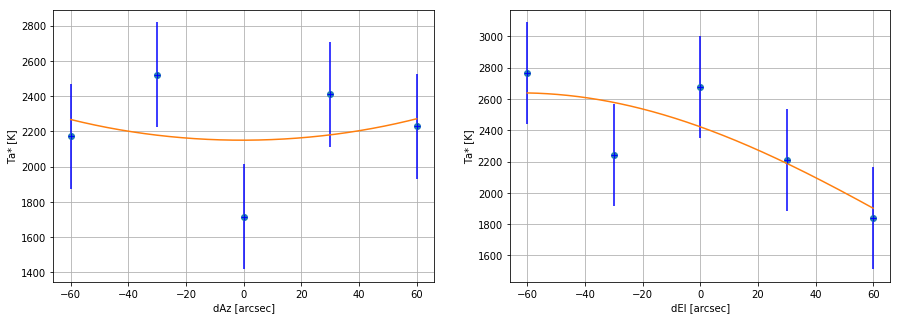

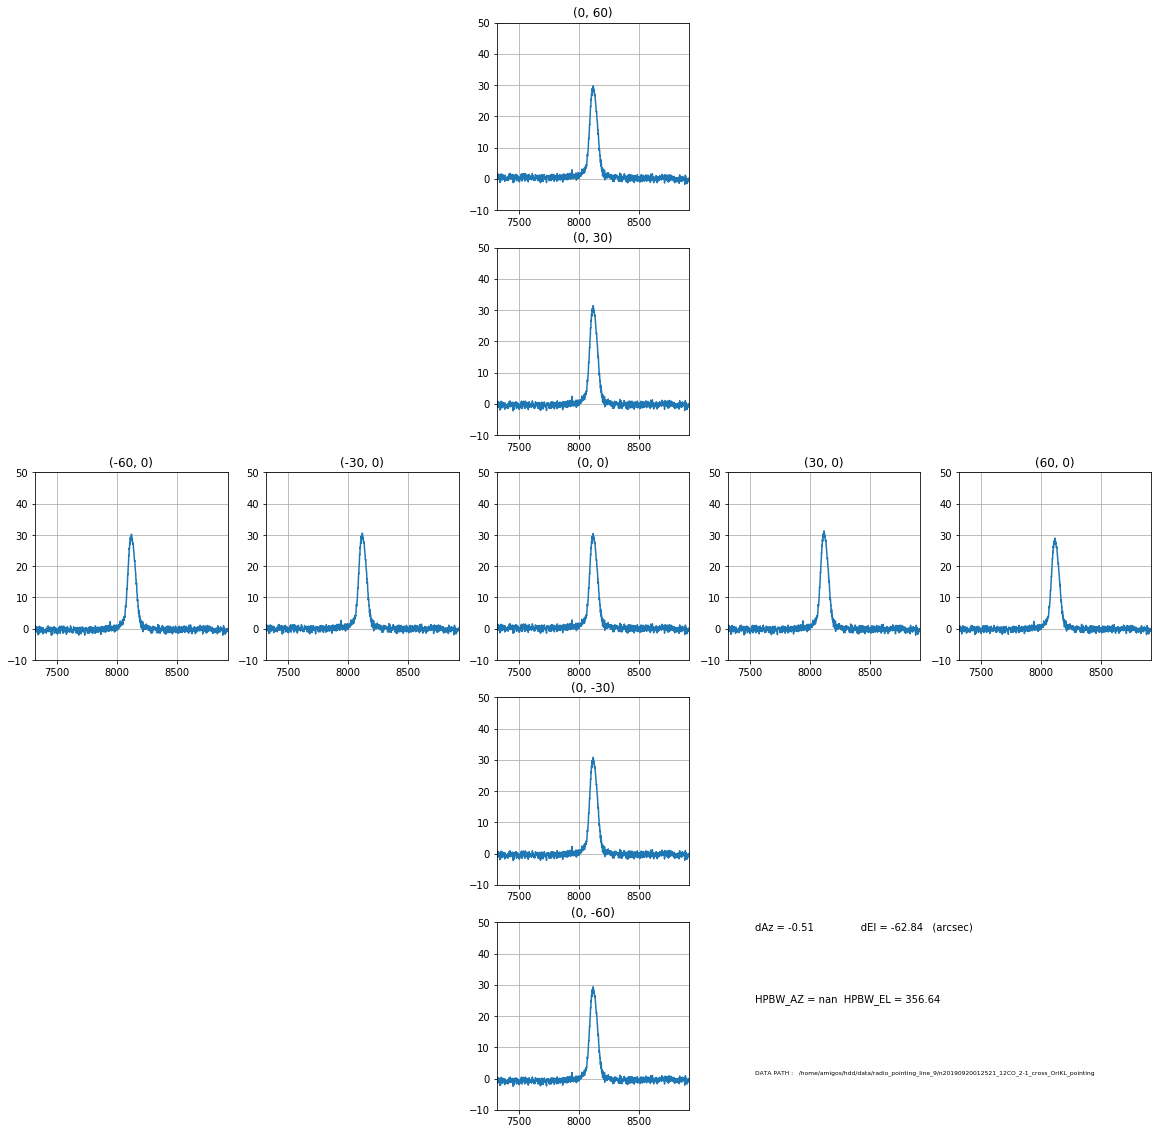

In [66]:
# Gaussian Fitting function
# Az fitting
try:
    popt_az, pcov_az = curve_fit(gaussian, xscan_x, xscan_integ, p0 = para_init, maxfev=10000)
    error_az = numpy.sqrt(numpy.diag(pcov_az))

    x_g = numpy.linspace(xscan_x[0], xscan_x[-1], 1001)
    gaus_az = gaussian(x_g, popt_az[0], popt_az[1], popt_az[2])

# El fitting
    popt_el, pcov_el = curve_fit(gaussian, yscan_y, yscan_integ, p0 = para_init, maxfev=10000)
    error_el = numpy.sqrt(numpy.diag(pcov_el))

    gaus_el = gaussian(x_g, popt_el[0], popt_el[1], popt_el[2])


# dAz dEl
    dAz = popt_az[1]
    dEl = popt_el[1]
    hpbw_az =  1/numpy.sqrt(2*popt_az[2]) *2.35
    hpbw_el = 1/numpy.sqrt(2*popt_el[2]) *2.35


# plot
    
    fig = plt.figure(figsize = (15, 5))

    axlist = [fig.add_subplot(1,2,i+1) for i in range(2)]

    axlist[0].plot(xscan_x, xscan_integ, "o")
    axlist[0].errorbar(xscan_x, xscan_integ, yerr = error_az[0], fmt = "b+")
    axlist[0].plot(x_g, gaus_az)
    axlist[0].set_xlabel("dAz [arcsec]")
    axlist[0].set_ylabel("Ta* [K]")

    axlist[1].plot(yscan_y, yscan_integ, "o")
    axlist[1].errorbar(yscan_y, yscan_integ, yerr = error_el[0], fmt = "b+")
    axlist[1].plot(x_g, gaus_el)
    axlist[1].set_xlabel("dEl [arcsec]")
    axlist[1].set_ylabel("Ta* [K]")
    
    [a.grid() for a in axlist]


    fig2 = plt.figure(figsize = (20,20))
        
    index_max = numpy.argmax(xscan_Ta[2][4000:12000]) + 4000 

    lim_mi = int(index_max - 800)
    lim_ma = int(index_max + 800)

    axlist = [fig2.add_subplot(5,5,i+1) for i in range(25)]
    axlist[2].plot(yscan_Ta[0])
    axlist[2].set_title("(0, 60)")
    axlist[2].set_xlim(lim_mi, lim_ma)
    axlist[2].set_ylim(-10,50)

    axlist[7].plot(yscan_Ta[1])
    axlist[7].set_title("(0, 30)")
    axlist[7].set_xlim(lim_mi, lim_ma)
    axlist[7].set_ylim(-10,50)

    axlist[10].plot(xscan_Ta[0])
    axlist[10].set_title("(-60, 0)")
    axlist[10].set_xlim(lim_mi, lim_ma)
    axlist[10].set_ylim(-10,50)

    axlist[11].plot(xscan_Ta[1])
    axlist[11].set_title("(-30, 0)")
    axlist[11].set_xlim(lim_mi, lim_ma)
    axlist[11].set_ylim(-10,50)

# axlist[12].plot(xscan_Ta[2])
    axlist[12].plot(yscan_Ta[2])
    axlist[12].set_title("(0, 0)")
    axlist[12].set_xlim(lim_mi, lim_ma)
    axlist[12].set_ylim(-10,50)

    axlist[13].plot(xscan_Ta[3])
    axlist[13].set_title("(30, 0)")
    axlist[13].set_xlim(lim_mi, lim_ma)
    axlist[13].set_ylim(-10,50)

    axlist[14].plot(xscan_Ta[4])
    axlist[14].set_title("(60, 0)")
    axlist[14].set_xlim(lim_mi, lim_ma)
    axlist[14].set_ylim(-10,50)

    axlist[17].plot(yscan_Ta[3])
    axlist[17].set_title("(0, -30)")
    axlist[17].set_xlim(lim_mi, lim_ma)
    axlist[17].set_ylim(-10,50)

    axlist[22].plot(yscan_Ta[4])
    axlist[22].set_title("(0, -60)")
    axlist[22].set_xlim(lim_mi, lim_ma)
    axlist[22].set_ylim(-10,50)

    axlist[0].set_visible(False)
    axlist[1].set_visible(False)
    axlist[3].set_visible(False)
    axlist[4].set_visible(False)
    axlist[5].set_visible(False)
    axlist[6].set_visible(False)
    axlist[8].set_visible(False)
    axlist[9].set_visible(False)
    axlist[15].set_visible(False)
    axlist[16].set_visible(False)
    axlist[18].set_visible(False)
    axlist[19].set_visible(False)
    axlist[20].set_visible(False)
    axlist[21].set_visible(False)
    axlist[23].set_visible(False)
    axlist[24].set_visible(False)

    [a.grid() for a in axlist]

    plt.axes([0.625,0.25, 0.25, 0.1])
    plt.axis("off")
    #plt.text(0, 0.5, "OBJECT :   {}".format(hdu[1].data["OBJECT"][0]), fontsize=10)
    plt.text(0,0,"dAz = {}".format(round(dAz, 2)) + "               dEl = {}".format(round(dEl, 2)) + "   (arcsec)", fontsize = 10)
    plt.text(0,-0.5,"HPBW_AZ = {}".format(round(hpbw_az, 2)) + "  HPBW_EL = {}".format(round(hpbw_el, 2)), fontsize = 10)
    plt.text(0, -1.0, "DATA PATH :   {}".format(path), fontsize=6)

except Exception as e:
    print("\033[31m[ERROR OCCURRED]\033[0m\n", e)
        
    # same as above
    fig2 = plt.figure(figsize = (20,20))
        
    axlist = [fig2.add_subplot(5,5,i+1) for i in range(25)]

    axlist[2].plot(yscan_Ta[0])
    axlist[2].set_title("(0, 60)")

    axlist[7].plot(yscan_Ta[1])
    axlist[7].set_title("(0, 30)")
  
    axlist[10].plot(xscan_Ta[0])
    axlist[10].set_title("(-60, 0)")

    axlist[11].plot(xscan_Ta[1])
    axlist[11].set_title("(-30, 0)")

# axlist[12].plot(xscan_Ta[2])
    axlist[12].plot(yscan_Ta[2])
    axlist[12].set_title("(0, 0)")

    axlist[13].plot(xscan_Ta[3])
    axlist[13].set_title("(30, 0)")

    axlist[14].plot(xscan_Ta[4])
    axlist[14].set_title("(60, 0)")

    axlist[17].plot(yscan_Ta[3])
    axlist[17].set_title("(0, -30)")

    axlist[22].plot(yscan_Ta[4])
    axlist[22].set_title("(0, -60)")

    axlist[0].set_visible(False)
    axlist[1].set_visible(False)
    axlist[3].set_visible(False)
    axlist[4].set_visible(False)
    axlist[5].set_visible(False)
    axlist[6].set_visible(False)
    axlist[8].set_visible(False)
    axlist[9].set_visible(False)
    axlist[15].set_visible(False)
    axlist[16].set_visible(False)
    axlist[18].set_visible(False)
    axlist[19].set_visible(False)
    axlist[20].set_visible(False)
    axlist[21].set_visible(False)
    axlist[23].set_visible(False)
    axlist[24].set_visible(False)

    plt.axes([0.625,0.25, 0.25, 0.1])
    plt.axis("off")
    plt.text(0, 0.5, "ERROR OCCURRED", fontsize=10)
    #plt.text(0, 0, "OBJECT :   {}".format(hdu[1].data["OBJECT"][0]), fontsize=10)
    plt.text(0, -0.5, "DATA PATH :   {}".format(path), fontsize=6)

    [a.grid() for a in axlist]

finally:
    if savefig:
        #plt.savefig(savepath_filename)
        pass
    if plot:
        plt.show()
    else:
        pass
 